In [2]:
import pandas as pd
import time
import geopandas
from glob import glob
from shapely.ops import cascaded_union
import pickle
import matplotlib as plt

In [3]:
bids = pd.read_csv("data/all_bids.csv")[["round", "bidder", "tier", "latency", "census_id"]]
bids["state"] = bids["census_id"]//10000000000
bids = bids.drop_duplicates(subset=["bidder", "census_id"])
bids

,round,bidder,tier,latency,census_id,state
0,1,Rainbow Communications LLC,Gigabit,Low,200050816001,20
1,1,Rainbow Communications LLC,Gigabit,Low,200050816002,20
2,1,Rainbow Communications LLC,Gigabit,Low,200050816003,20
3,1,Rainbow Communications LLC,Gigabit,Low,200050816005,20
4,1,Rainbow Communications LLC,Gigabit,Low,200050817002,20
...,...,...,...,...,...,...
4038929,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159503002,27
4038930,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159504001,27
4039029,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,270753701003,27
4039401,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,550539604003,55


In [124]:
existing = pd.read_csv("data/existing_service.csv", encoding="latin")
existing["bg"] = existing["BlockCode"]//1000
existing  = existing.loc[(existing["MaxAdDown"]>=25) & (existing["MaxAdUp"]>=3) & (existing["TechCode"]!=60)]
existing["state"] = existing["bg"]//10000000000
existing['names'] = [frozenset(x) for x in zip(existing.ProviderName, existing.HoldingCompanyName, existing.DBAName, existing.HocoFinal)]
existing

,LogRecNo,Provider_Id,FRN,ProviderName,DBAName,HoldingCompanyName,HocoNum,HocoFinal,StateAbbr,BlockCode,TechCode,Consumer,MaxAdDown,MaxAdUp,Business,bg,state,names
0,1,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139501002019,70,1,40.0,10.0,1,410139501002,41,"(Webformix, Webformix Company)"
1,2,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139503002023,70,1,40.0,10.0,1,410139503002,41,"(Webformix, Webformix Company)"
2,3,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139502002027,70,1,40.0,10.0,1,410139502002,41,"(Webformix, Webformix Company)"
3,4,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139501003004,70,1,40.0,10.0,1,410139501003,41,"(Webformix, Webformix Company)"
4,5,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139504001109,70,1,40.0,10.0,1,410139504001,41,"(Webformix, Webformix Company)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42151570,42151571,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003006,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., OSNET Wireless, Osnet W..."
42151571,42151572,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003005,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., OSNET Wireless, Osnet W..."
42151572,42151573,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003004,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., OSNET Wireless, Osnet W..."
42151573,42151574,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003003,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., OSNET Wireless, Osnet W..."


In [4]:
existing = existing.drop_duplicates(subset=['bg'])
existing_bg = set(existing["bg"].tolist())
bid_bg = set(bids["census_id"].tolist())
print(len(existing_bg))
print(len(bid_bg))
print(len(existing_bg.intersection(bid_bg)))

219391
61766
61021


In [5]:
eligible = pd.read_csv("data/auction904_updated_block_cbg.csv")
eligible_bg = eligible["cbg_id"].tolist()
print(len(set(eligible_bg)))
eligible_b = eligible["block_id"].tolist()
existing_b = set(existing["BlockCode"].tolist())
print(len(existing_b))
print(len(eligible_b))
intersect = existing_b.intersection(eligible_b)
print(len(existing_b.intersection(eligible_b)))
print(list(intersect)[:5])


61766
Empty DataFrame
Columns: [LogRecNo, Provider_Id, FRN, ProviderName, DBAName, HoldingCompanyName, HocoNum, HocoFinal, StateAbbr, BlockCode, TechCode, Consumer, MaxAdDown, MaxAdUp, Business, bg, state]
Index: []
219391
786952
5111
[420270105002003, 120830002004001, 181339561001005, 211390402003009, 60650422141000]


In [59]:
shapefiles = glob("data/all_data/*.shp")
county_shapes = []
for file in  shapefiles:
    county_shapes.append(geopandas.read_file(file))

county_shapes = pd.concat(county_shapes)[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE", "GEOID", "geometry"]]
county_shapes["GEOID"] = pd.to_numeric(county_shapes["GEOID"])
county_shapes

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,geometry,GEOID20
0,05,143,010503,2,051430105032,"POLYGON ((-94.21915 36.17593, -94.21718 36.175...",51430105032
1,05,143,010504,1,051430105041,"POLYGON ((-94.33762 35.97984, -94.33724 35.980...",51430105041
2,05,143,010504,5,051430105045,"POLYGON ((-94.43864 35.95907, -94.43852 35.959...",51430105045
3,05,143,010506,1,051430105061,"POLYGON ((-94.24059 36.04502, -94.24058 36.045...",51430105061
4,05,135,470200,7,051354702007,"POLYGON ((-91.54745 36.26023, -91.54734 36.260...",51354702007
...,...,...,...,...,...,...,...
3921,24,003,740601,4,240037406014,"POLYGON ((-76.77774 39.11425, -76.77746 39.114...",240037406014
3922,24,510,160500,1,245101605001,"POLYGON ((-76.66090 39.30614, -76.66017 39.306...",245101605001
3923,24,510,160500,2,245101605002,"POLYGON ((-76.65502 39.29848, -76.65464 39.298...",245101605002
3924,24,510,160500,3,245101605003,"POLYGON ((-76.65941 39.29463, -76.65892 39.294...",245101605003


In [73]:
try:
    state_shapes = pickle.load(open("state_shapes.pkl", "rb" ))
except FileNotFoundError:
    state_shapes = county_shapes.groupby("STATEFP")["geometry"].apply(list).reset_index(name="geometry")
    state_shapes["geometry"] = state_shapes["geometry"].apply(cascaded_union)
    state_shapes = geopandas.GeoDataFrame(state_shapes)
    for index, row in state_shapes.iterrows():
        neighbors = state_shapes[~state_shapes.geometry.disjoint(row['geometry'])]
        state_shapes.at[index, "neighbors"] = ", ".join(neighbors.STATEFP.tolist())
    with open('state_shapes.pkl', 'wb') as f:
        pickle.dump(state_shapes, f)
state_shapes

,STATEFP,geometry,neighbors
0,01,"POLYGON ((-87.43079 30.40491, -87.43088 30.404...","01, 12, 13, 28, 47"
1,02,"MULTIPOLYGON (((-179.23023 51.28393, -179.2256...",02
2,04,"POLYGON ((-109.49449 31.33398, -109.49874 31.3...","04, 06, 08, 32, 35, 49"
3,05,"POLYGON ((-91.18636 33.10060, -91.18412 33.099...","05, 22, 28, 29, 40, 47, 48"
4,06,"MULTIPOLYGON (((-119.63607 33.28071, -119.6347...","04, 06, 32, 41"
5,08,"POLYGON ((-102.04158 37.64428, -102.04159 37.6...","04, 08, 20, 31, 35, 40, 49, 56"
6,09,"POLYGON ((-73.64983 40.97920, -73.65637 40.984...","09, 25, 36, 44"
7,10,"POLYGON ((-75.04760 38.45126, -75.04874 38.451...","10, 24, 34, 42"
8,11,"POLYGON ((-76.99111 38.82915, -76.99119 38.829...","11, 24, 51"
9,12,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ...","01, 12, 13"


In [ ]:
with open("neighbors.log", "w") as log:
    pass

total_time = 0
processed_bid_dict = {}
for state_code in state_shapes["STATEFP"].tolist():
    start = time.time()
    state_bids = bids.loc[bids["state"]==int(state_code)]
    state_bids = state_bids.groupby("census_id")["bidder"].apply(set).reset_index(name="bidder")
    state_bids = state_bids.merge(county_shapes, left_on="census_id", right_on="GEOID")

    neighbors = state_shapes.loc[state_shapes["STATEFP"] == state_code]["neighbors"].item().split(", ")
    neighbors = [int(n) for n in neighbors]
    state_existing = existing.loc[existing["state"].isin(neighbors)]
    state_existing = state_existing.groupby("bg")["names"].apply(set).reset_index(name="names")
    state_existing = state_existing.merge(county_shapes, left_on="bg", right_on="GEOID")
    state_existing = geopandas.GeoDataFrame(state_existing)

    for index, row in state_bids.iterrows():
        neighbors = state_existing[~state_existing.geometry.disjoint(row['geometry'])]
        ids = neighbors.GEOID.tolist()
        list_set_set_names = neighbors.names.tolist()
        bidders = row.bidder
        out = {}
        for idx, set_set_names in zip(ids, list_set_set_names):
            for name_possibilities in set_set_names:
                for bidder in bidders:
                    if bidder in name_possibilities:
                        running = out.get(bidder, [])
                        running.append(idx)
                        out[bidder] = running
        state_bids.at[index, "neighbors"] = [out]
    state_time = time.time()-start
    with open("neighbors.log", "a") as log:
        log.write(f"{state_code} {state_time}\n")
    total_time += state_time
    processed_bid_dict[state_code] = state_bids

with open("neighbors.log", "a") as log:
    log.write(f"final time {total_time}")

with open('neighbors.pkl', 'wb') as f:
    pickle.dump(processed_bid_dict, f)

In [138]:
neighbors = {}
state = "01"
for d in [x[0] for x in processed_bid_dict[state].neighbors.tolist()]:
    for k, v in d.items():
        running = neighbors.get(k, [])
        running += v
        neighbors[k] = running

In [147]:
name

'CoBridge Communications'

<AxesSubplot:>

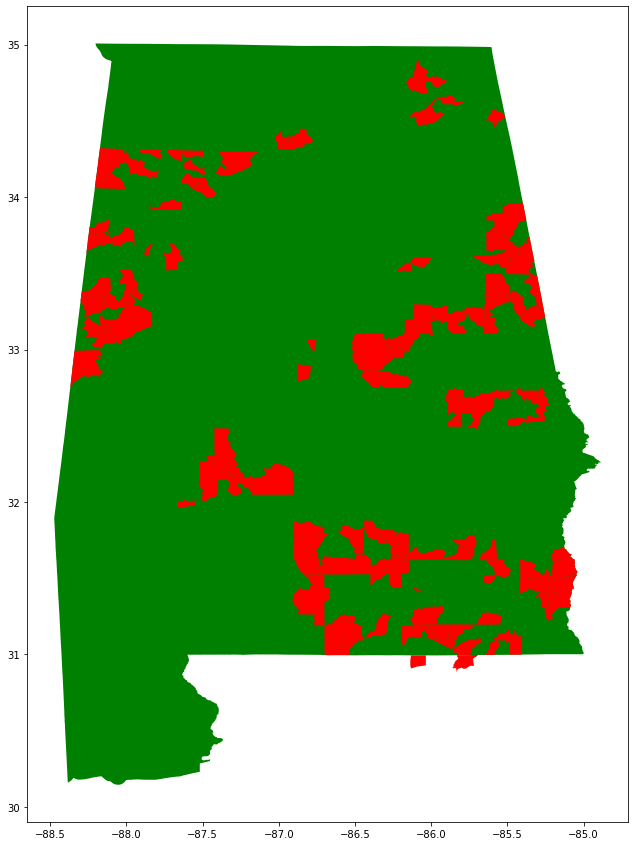

In [144]:
selected_bidder = "CoBridge Communications"
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df.loc[0] = ['green', state_shapes.loc[state_shapes["STATEFP"] == state].geometry.item()] 

df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(neighbors[selected_bidder])].geometry
df1["color"] = "red"

df2["geometry"] = all_neighbors.loc[all_neighbors["bidder"]==selected_bidder].geometry
df2["color"] = "blue"

df = pd.concat([df, df1, df2])

df.plot(color=df['color'], figsize=(20, 15))
#     fig = plot.get_figure()
#     fig.savefig(f"{selected_bidder}.png")

<AxesSubplot:>

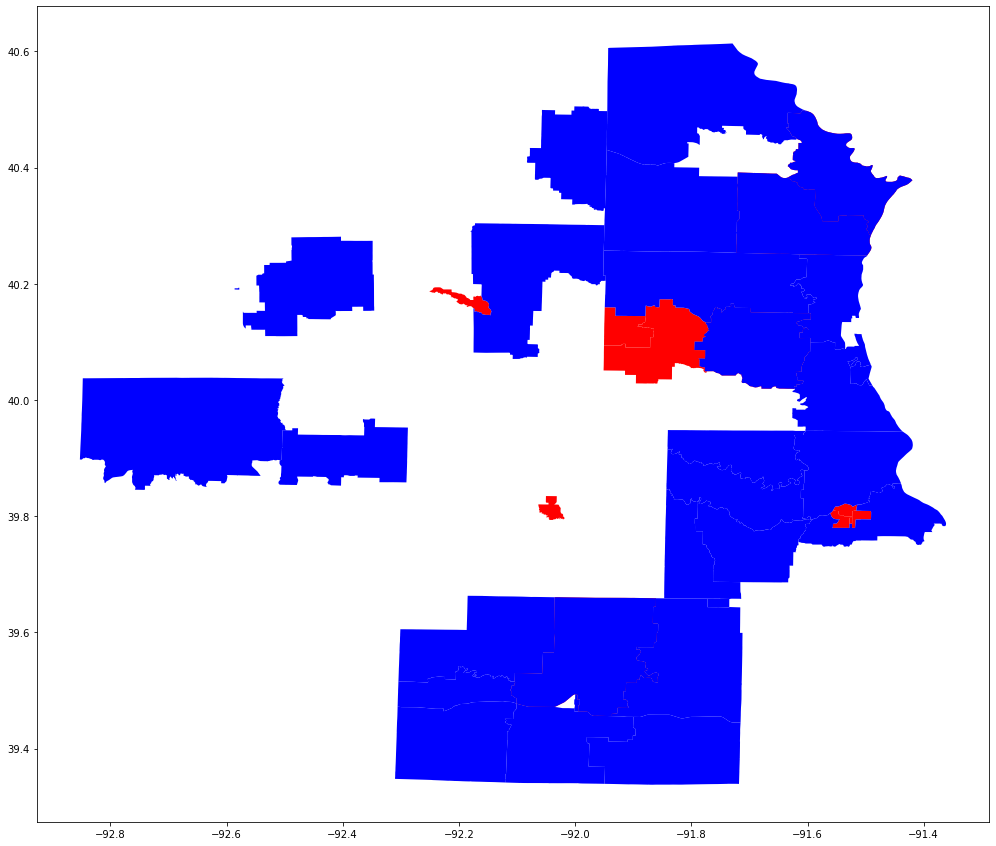

In [105]:
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
# df.loc[0] = ['green', state_shapes.loc[state_shapes["STATEFP20"] == "06"].geometry.item()] 

df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1["geometry"] = county_shapes.loc[county_shapes.GEOID20.isin(existing.loc[existing.DBAName==selected_bidder].bg.tolist())].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID20.isin(bids.loc[bids["bidder"]==selected_bidder].census_id.tolist())].geometry
df2["color"] = "blue"

df = pd.concat([df, df1, df2])

df.plot(color=df['color'], figsize=(20, 15))

In [6]:
set([y for x in state_existing.loc[state_existing["STATEFP20"]=="06"].DBAName.tolist() for y in x]).intersection(set(bids.loc[(bids["state"]==int("06"))& (bids["bidder"]) ].bidder.unique()))

NameError: name 'state_existing' is not defined

In [7]:
set(existing.DBAName.unique()).intersection(set(bids.bidder.unique()))

{'Amherst Telephone Company',
 'Arrowhead Electric Cooperative, Inc.',
 'Atlantic Broadband Finance, LLC',
 'Atlantic Telephone Membership Corporation',
 'B2X Online, Inc.',
 'BEK Communications Cooperative',
 'Bay Springs Telephone Company, Inc.',
 'Blackfoot Telephone Cooperative, Inc.',
 'Broadband Corp',
 'Chariton Valley Communications Corporation',
 'Colorado Central Telecom, Inc.',
 'Conifer Communications',
 'Corn Belt Telephone',
 'Custer Telephone Cooperative, Inc.',
 'Falcon Internet',
 'Fundamental Holdings Corp dba Peak Internet',
 'Grand Mound Cooperative Telephone Association',
 'Hankins Information Technology',
 'Hawaii Dialogix Telecom LLC',
 'Heart of Iowa Communications Cooperative',
 'Huxley Communications Cooperative',
 'Leap Communications, LLC',
 'MEI Telecom, Inc.',
 'Mark Twain Communications Company',
 'Midcontinent Communications',
 'Mountain West Technologies Corporation',
 'Newport Utilities',
 'Northeast Missouri Rural Telephone Company',
 'Northwest Commu

In [125]:
state_existing = existing
state_existing = state_existing.groupby("bg")["names"].apply(set).reset_index(name="names")
state_existing

,bg,names
0,10010201001,"{(WOW, WideOpenWest Finance, LLC, Knology of A..."
1,10010201002,"{(WOW, WideOpenWest Finance, LLC, Knology of A..."
2,10010202001,"{(WOW, WideOpenWest Finance, LLC, Knology of A..."
3,10010202002,"{(WOW, WideOpenWest Finance, LLC, Knology of A..."
4,10010203001,"{(WOW, WideOpenWest Finance, LLC, Knology of A..."
...,...,...
219386,780309611001,"{(Vitelcom Cellular, Inc. d/b/a Innovative Wir..."
219387,780309611002,"{(Vitelcom Cellular, Inc. d/b/a Innovative Wir..."
219388,780309612001,"{(Vitelcom Cellular, Inc. d/b/a Innovative Wir..."
219389,780309612002,"{(Vitelcom Cellular, Inc. d/b/a Innovative Wir..."


TypeError: unhashable type: 'set'